여러 속성들을 합쳐서 새로운 지수(속성)을 만들어 신용도와 연관이 생길지 생각해보기

모델돌리고 잘 찾지 못한, 오류난 행을 찾아보기

여러모델 돌리고 앙상블하기

In [ ]:
!pip install Bayesian-Optimization

In [ ]:
!pip install catboost

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data_path = "/content/drive/My Drive/python/credit"

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lightgbm import plot_importance
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from bayes_opt import BayesianOptimization
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import random
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_validate

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 출력 행, 열 갯수 정하기
# pd.set_option('display.max_row', 1000)
# pd.set_option('display.max_columns', 100)

In [ ]:
tr = pd.read_csv(data_path + "/train.csv")
te = pd.read_csv(data_path + "/test.csv")

In [ ]:
# tr.info()
# te.info()

In [ ]:
tr1 = tr.drop(['index','FLAG_MOBIL'], axis=1)
te1 = te.drop(['index','FLAG_MOBIL'], axis=1)

In [ ]:
# tr1.isnull().sum()

In [ ]:
# te1.isnull().sum()

In [ ]:
# tr1[tr1['occyp_type'].isnull()][tr1['credit'] == 0]

In [ ]:
# natr = tr1[tr1['occyp_type'].isnull()]
# natr['credit'].value_counts()

In [ ]:
#NaN값 ETC로 변경
tr1['occyp_type'].fillna("ETC",inplace=True)
# tr1['occyp_type'].value_counts()
te1['occyp_type'].fillna("ETC",inplace=True)
# te1['occyp_type'].value_counts()

In [ ]:
# #중복유무확인
# tr1.duplicated().value_counts()

In [ ]:
# tr1.drop(['begin_month'],axis=1).duplicated().value_counts()

In [ ]:
#중복제거
# tr1 = tr1.drop_duplicates()
#tr1.info()


#중복제거는 확률구하는데 있어서 모든 경우가 다 필요하므로 제거하지않기로 결정함
#다만 신용도도 같은 중복은 필요가 없지않을까?


In [ ]:
# tr1 = tr1.reset_index(drop=True)

In [ ]:
#성별 gender
# tr1['gender'].value_counts()

In [ ]:
# pd.crosstab(tr1.gender, tr1.credit)

In [ ]:
#자동차 유무 car 
# tr1['car'].value_counts()

In [ ]:
# pd.crosstab(tr1.car, tr1.credit)

In [ ]:
#부동산 유무 reality 
# tr1['reality'].value_counts()

In [ ]:
# pd.crosstab(tr1.reality, tr1.credit)

In [ ]:
# tr1['credit'].loc[tr1['car'] == 'N'].loc[tr1['reality'] == 'N'].value_counts()

In [ ]:
# tr1['credit'].loc[tr1['car'] == 'Y'].loc[tr1['reality'] == 'N'].value_counts()

In [ ]:
# tr1['credit'].loc[tr1['car'] == 'N'].loc[tr1['reality'] == 'Y'].value_counts()

In [ ]:
# tr1['credit'].loc[tr1['car'] == 'Y'].loc[tr1['reality'] == 'Y'].value_counts()

In [ ]:
#자식 수 child_num
# tr1["child_num"].value_counts()

# tr1.loc[tr1['child_num'] >= 4]

In [ ]:
# te1['child_num'].loc[te1['child_num'] >= 4].value_counts()

In [ ]:
#자식 수 범위 축소
tr1.loc[tr1['child_num'] >= 3,'child_num']=3
te1.loc[te1['child_num'] >= 3,'child_num']=3

In [ ]:
# te1["child_num"].value_counts()

In [ ]:
# tr1["child_num"].value_counts()

In [ ]:
# pd.crosstab(tr1.child_num, tr1.credit, normalize= True,margins=True)

In [ ]:
#연간 소득 income_total
# tr1['income_total'].describe()

In [ ]:
# plt.boxplot(tr1['income_total'])
# plt.show()

In [ ]:
#수입 로그수치화
tr1["log_income_total"] = np.log1p(tr1["income_total"])
te1["log_income_total"] = np.log1p(te1["income_total"])

In [ ]:
# plt.hist(tr1['log_income_total'])
# plt.show()

In [ ]:
#소득 분류 income_type
# tr1["income_type"].value_counts()

In [ ]:
# tr1.loc[tr1['income_type'] == 'Student'].sort_values(by=['DAYS_EMPLOYED'])

In [ ]:
# te1["income_type"].value_counts()

In [ ]:
# te1.loc[te1['income_type'] == 'Student']

In [ ]:
# pd.crosstab(tr1.income_type, tr1.credit )

In [ ]:
# 교육 수준 edu_type
# tr1["edu_type"].value_counts()

In [ ]:
# te1["edu_type"].value_counts()

In [ ]:
#교육수준 수 조절
tr1.loc[tr1['edu_type'] == 'Lower secondary', 'edu_type'] = 'Secondary / secondary special'
te1.loc[te1['edu_type'] == 'Lower secondary', 'edu_type'] = 'Secondary / secondary special'
tr1.loc[tr1['edu_type'] == 'Incomplete higher','edu_type'] = 'Higher education'
te1.loc[te1['edu_type'] == 'Incomplete higher','edu_type'] = 'Higher education'
te1.loc[te1['edu_type'] == 'Academic degree','edu_type'] = 'Higher education'
tr1.loc[tr1['edu_type'] == 'Academic degree','edu_type'] = 'Higher education'

In [ ]:
# pd.crosstab(tr1.edu_type, tr1.credit)

In [ ]:
#결혼유형 family_type
# tr1["family_type"].value_counts()

In [ ]:
# pd.crosstab(tr1.family_type, tr1.credit)

In [ ]:
#생활 유형 house_type
# tr1["house_type"].value_counts()

In [ ]:
# pd.crosstab(tr1.house_type, tr1.credit)

In [ ]:
#출생일 DAYS_BIRTH
tr1['DAYS_BIRTH'] = -tr1['DAYS_BIRTH']
te1['DAYS_BIRTH'] = -te1['DAYS_BIRTH']

In [ ]:
# sns.boxplot(tr1['credit'],tr1['DAYS_BIRTH'])
# plt.show()
#tr1['DAYS_BIRTH'].describe()

In [ ]:
tr1['age'] = round(tr1['DAYS_BIRTH']/365, 0)
te1['age'] = round(te1['DAYS_BIRTH']/365, 0)

In [ ]:
# tr1['age'].value_counts()

In [ ]:
# te1['age'].value_counts()

In [ ]:
#취직일 DAYS_EMPLOYED
# tr1['DAYS_EMPLOYED'].describe()
# plt.boxplot(tr1['DAYS_EMPLOYED'])

In [ ]:
# te1['DAYS_EMPLOYED'].describe()
# plt.boxplot(te1['DAYS_EMPLOYED'])

In [ ]:
# tr1[tr1['DAYS_EMPLOYED'] > 0]['credit'].value_counts()

In [ ]:
# tr1[tr1['DAYS_EMPLOYED'] > 0].describe()

In [ ]:
tr1.loc[tr1['DAYS_EMPLOYED'] > 0, 'DAYS_EMPLOYED'] = 1
te1.loc[te1['DAYS_EMPLOYED'] > 0, 'DAYS_EMPLOYED'] = 1
tr1['DAYS_EMPLOYED'] = -tr1['DAYS_EMPLOYED']
te1['DAYS_EMPLOYED'] = -te1['DAYS_EMPLOYED']

In [ ]:
# tr1['DAYS_EMPLOYED'].describe()

In [ ]:
# plt.hist(tr1['DAYS_EMPLOYED'])
# plt.show()

In [ ]:
#업무용 전화 소유 여부 work_phone
# tr1["work_phone"].value_counts()

In [ ]:
# pd.crosstab(tr1.work_phone, tr1.credit)

In [ ]:
#집전화 소유 여부 phone 
# tr1["phone"].value_counts()

In [ ]:
# pd.crosstab(tr1.phone, tr1.credit)

In [ ]:
# 이메일 소유 여부 email
# tr1["email"].value_counts()

In [ ]:
# pd.crosstab(tr1.email, tr1.credit)

In [ ]:
#직업 유형 occyp_type
# tr1["occyp_type"].value_counts()

In [ ]:
# pd.crosstab(tr1.occyp_type, tr1.credit)

In [ ]:
#업종 수 줄이기
tr1.loc[tr1['occyp_type'] == 'HR staff', 'occyp_type'] = 'Low-skill Laborers'
te1.loc[te1['occyp_type'] == 'HR staff', 'occyp_type'] = 'Low-skill Laborers'
tr1.loc[tr1['occyp_type'] == 'Cleaning staff', 'occyp_type'] = 'Cooking staff'
te1.loc[te1['occyp_type'] == 'Cleaning staff', 'occyp_type'] = 'Cooking staff'
tr1.loc[tr1['occyp_type'] == 'Secretaries', 'occyp_type'] = 'Waiters/barmen staff'
te1.loc[te1['occyp_type'] == 'Secretaries', 'occyp_type'] = 'Waiters/barmen staff'

In [ ]:
#가족 규모 family_size
# tr1["family_size"].value_counts()
# tr1.loc[tr1['family_size'] > 7]

In [ ]:
# te1["family_size"].value_counts()

In [ ]:
#가족 수 줄이기
tr1.loc[tr1['family_size'] > 3, 'family_size'] = 4
te1.loc[te1['family_size'] > 3, 'family_size'] = 4

In [ ]:
# pd.crosstab(tr1.family_size, tr1.credit)

In [ ]:
#신용카드 발급 월 begin_month
# tr1['begin_month'].describe()
tr1['begin_month'] = -tr1['begin_month']
tr1['use_year'] = round(tr1['begin_month']/12,2)
te1['begin_month'] = -te1['begin_month']
te1['use_year'] = round(te1['begin_month']/12,2)

In [ ]:
#sns.boxplot(tr1['credit'],tr1['use_year'])

In [ ]:
#pd.crosstab(tr1['use_year'], tr1['credit'])

In [ ]:
# tr1.head(5)

In [ ]:
# te1.head(5)

In [ ]:
#변수별 산점도
# sns.pairplot(data=tr1)
# plt.show()

In [ ]:
tr1.corr()

,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,family_size,begin_month,credit,log_income_total,age,use_year
child_num,1.000000,0.034306,-0.346882,0.044621,0.052940,-0.010794,0.019015,0.864426,0.007730,0.003410,0.038292,-0.346537,0.007703
income_total,0.034306,1.000000,-0.064155,0.086919,-0.034207,0.019013,0.089882,0.026418,0.018047,0.008555,0.921367,-0.063916,0.018070
DAYS_BIRTH,-0.346882,-0.064155,1.000000,-0.020340,-0.178752,0.029247,-0.111238,-0.308891,0.057306,0.025187,-0.105269,0.999683,0.057314
DAYS_EMPLOYED,0.044621,0.086919,-0.020340,1.000000,0.108569,0.041884,0.002918,0.057348,0.082665,0.022823,0.101074,-0.019614,0.082677
work_phone,0.052940,-0.034207,-0.178752,0.108569,1.000000,0.310256,-0.031048,0.071829,0.008563,-0.003134,-0.046067,-0.178647,0.008564
phone,-0.010794,0.019013,0.029247,0.041884,0.310256,1.000000,0.012494,0.001588,0.014286,0.003452,0.001468,0.028916,0.014284
email,0.019015,0.089882,-0.111238,0.002918,-0.031048,0.012494,1.000000,0.019508,-0.002320,0.014812,0.091717,-0.111056,-0.002307
family_size,0.864426,0.026418,-0.308891,0.057348,0.071829,0.001588,0.019508,1.000000,0.024196,0.007979,0.025390,-0.308564,0.024187
begin_month,0.007730,0.018047,0.057306,0.082665,0.008563,0.014286,-0.002320,0.024196,1.000000,0.147477,0.023768,0.057308,0.999998
credit,0.003410,0.008555,0.025187,0.022823,-0.003134,0.003452,0.014812,0.007979,0.147477,1.000000,0.005539,0.025109,0.147486


In [ ]:
#상관관계가 높아 보이는 것들 제거
tr2 = tr1.drop(['family_size', 'income_total', 'DAYS_BIRTH', 'begin_month'], axis = 1)
te2 = te1.drop(['family_size', 'income_total', 'DAYS_BIRTH', 'begin_month'], axis = 1)

=================================================================================================

In [ ]:
#  tr2.info()

In [ ]:
object_col = []
for col in tr2.columns:
    if tr2[col].dtype == 'object':
        object_col.append(col)

In [ ]:
object_col

['gender',
 'car',
 'reality',
 'income_type',
 'edu_type',
 'family_type',
 'house_type',
 'occyp_type']

In [ ]:
enc = LabelEncoder()

In [ ]:
for col in object_col:
    enc.fit(pd.concat([tr2[col], te2[col]], axis=0, sort=False))
    tr2[col] = enc.transform(tr2[col])
    te2[col] = enc.transform(te2[col])

In [ ]:
# enc = LabelEncoder()
# tr2.income_type = enc.fit_transform(tr2.income_type)
# tr2.gender = enc.fit_transform(tr2.gender)
# tr2.car = enc.fit_transform(tr2.car)
# tr2.reality = enc.fit_transform(tr2.reality)
# tr2.edu_type = enc.fit_transform(tr2.edu_type)
# tr2.family_type = enc.fit_transform(tr2.family_type)
# tr2.house_type = enc.fit_transform(tr2.house_type)
# tr2.occyp_type = enc.fit_transform(tr2.occyp_type)

In [ ]:
tr2.info()

In [ ]:
# enc = LabelEncoder()
# te2.income_type = enc.fit_transform(te2.income_type)
# te2.gender = enc.fit_transform(te2.gender)
# te2.car = enc.fit_transform(te2.car)
# te2.reality = enc.fit_transform(te2.reality)
# te2.edu_type = enc.fit_transform(te2.edu_type)
# te2.family_type = enc.fit_transform(te2.family_type)
# te2.house_type = enc.fit_transform(te2.house_type)
# te2.occyp_type = enc.fit_transform(te2.occyp_type)

In [ ]:
te2.info()

============================================================================================

In [ ]:
sub = pd.read_csv(data_path + "/sample_submission.csv")

====================================================================================================

In [ ]:
#원본데이터
X_train, X_test, y_train, y_test = train_test_split(tr2.drop(['credit'],axis=1),  tr2['credit'], test_size=0.2, random_state=156)
lgbm_wrapper = LGBMClassifier(n_estimators=1000)
evals = [(X_test, y_test)]
lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds=300, eval_metric='logloss', eval_set=evals, verbose=100)
pred = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:1]

Training until validation scores don't improve for 300 rounds.
[100]	valid_0's multi_logloss: 0.762042	valid_0's multi_logloss: 0.762042
[200]	valid_0's multi_logloss: 0.745961	valid_0's multi_logloss: 0.745961
[300]	valid_0's multi_logloss: 0.739523	valid_0's multi_logloss: 0.739523
[400]	valid_0's multi_logloss: 0.735917	valid_0's multi_logloss: 0.735917
[500]	valid_0's multi_logloss: 0.736656	valid_0's multi_logloss: 0.736656
[600]	valid_0's multi_logloss: 0.739259	valid_0's multi_logloss: 0.739259
[700]	valid_0's multi_logloss: 0.744649	valid_0's multi_logloss: 0.744649
Early stopping, best iteration is:
[428]	valid_0's multi_logloss: 0.735145	valid_0's multi_logloss: 0.735145


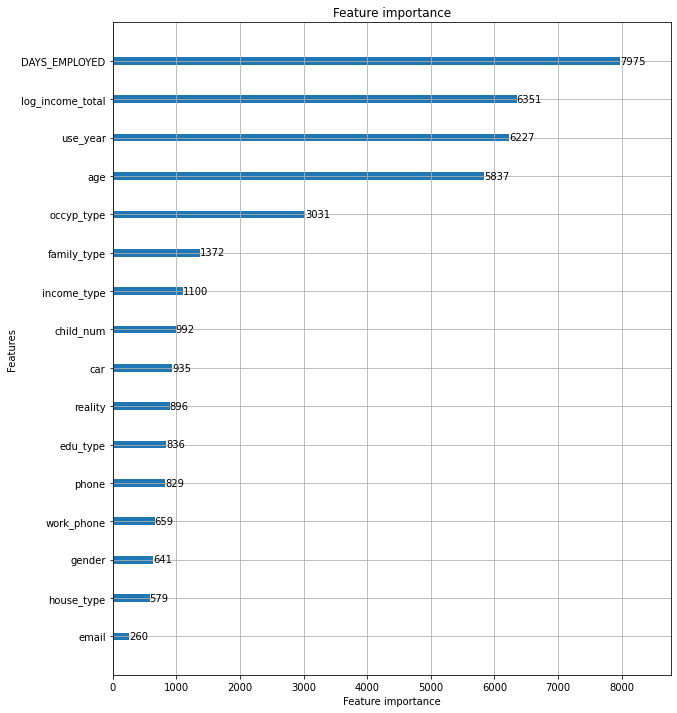

In [ ]:
fig, ax = plt.subplots(figsize=(10,12))
plot_importance(lgbm_wrapper, ax=ax)
plt.show()

In [ ]:
tr2 = tr2.drop(['email'], axis=1)
te2 = te2.drop(['email'], axis=1)

In [ ]:
# tr2.info()

=========================================================================================================


베이지안 최적화로 파라미터 찾았을때

In [ ]:
def lgbm_cv(learning_rate, n_estimators, num_leaves):
    model = LGBMClassifier(learning_rate=learning_rate,
                                n_estimators = int(n_estimators),
                                num_leaves = int(round(num_leaves))
    )
  
    X_train, X_valid, y_train, y_valid = train_test_split(tr2.drop(['credit'],axis=1), tr2['credit'], test_size=0.2, random_state=156)
    evals = [(X_valid, y_valid)]
    model.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='logloss', eval_set=evals, verbose=100)
    score = 100-abs(cross_val_score(model, X_valid, y_valid, scoring='neg_log_loss', cv=4, n_jobs=-1).mean())

    return score

In [ ]:
pbounds = {
    'learning_rate' : (0.001, 0.15),
    'n_estimators' : (1000, 10000),
    'num_leaves': (200, 1000)
}

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
lgbmB = BayesianOptimization(f = lgbm_cv, pbounds = pbounds, verbose = 2, random_state = 156)


In [ ]:
lgbmB.maximize(init_points=5, n_iter = 5)

In [ ]:
# Maximize를 통해 나온 Parameter가 저장되어있습니다.
max_params_lgbm = lgbmB.max['params']
# max_params['max_depth'] = int(round(max_params['max_depth'])) # Max_depth는 int값을 받기에 int로 변환합니다.
# max_params['n_estimators'] = int(round(max_params['n_estimators'])) # n_estimators는 int값을 받기에 int로 변환합니다.

max_params_lgbm['num_leaves']= int(round(max_params_lgbm['num_leaves']))
max_params_lgbm['n_estimators']= int(round(max_params_lgbm['n_estimators']))
print(max_params_lgbm)

# Model에 저장된 param을 지정해 저장후, 재 학습을 통해 predict합니다.
# model_lgbm = LGBMClassifier(**max_params)

{'learning_rate': 0.001, 'n_estimators': 2295, 'num_leaves': 672}


In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=6)
folds=[]
for train_idx, valid_idx in skf.split(tr2, tr2['credit']):
    folds.append((train_idx, valid_idx))

In [ ]:
random.seed(6)
lgb_models={}
for fold in range(5):
    print(f'===================================={fold+1}============================================')
    train_idx, valid_idx = folds[fold]
    X_train = tr2.drop(['credit'],axis=1).iloc[train_idx].values
    X_valid = tr2.drop(['credit'],axis=1).iloc[valid_idx].values
    y_train = tr2['credit'][train_idx].values
    y_valid = tr2['credit'][valid_idx].values
    lgb = LGBMClassifier(**max_params_lgbm)
    lgb.fit(X_train, y_train, 
            eval_set=(X_valid, y_valid), 
            early_stopping_rounds=500,
           verbose=100)
    lgb_models[fold]=lgb
    print(f'================================================================================\n\n')


In [ ]:
sub.iloc[:,1:]=0
for fold in range(5):
    sub.iloc[:,1:] += lgb_models[fold].predict_proba(te2)/5

In [ ]:
sub.head(10)

,index,0,1,2
0,26457,0.069779,0.159326,0.770895
1,26458,0.194033,0.162803,0.643163
2,26459,0.052371,0.102294,0.845335
3,26460,0.095188,0.117016,0.787795
4,26461,0.126503,0.179734,0.693764
5,26462,0.109987,0.180772,0.709241
6,26463,0.204640,0.666544,0.128816
7,26464,0.077621,0.107086,0.815293
8,26465,0.054125,0.191466,0.754409
9,26466,0.056065,0.311838,0.632097


In [ ]:
sub.to_csv(data_path + "/subBO.csv", index=False)

===================================================================================================================

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=6)
folds=[]
for train_idx, valid_idx in skf.split(tr2, tr2['credit']):
    folds.append((train_idx, valid_idx))

In [ ]:
#lgbm
random.seed(6)
lgb_models={}
for fold in range(5):
    print(f'===================================={fold+1}============================================')
    train_idx, valid_idx = folds[fold]
    X_train = tr2.drop(['credit'],axis=1).iloc[train_idx].values
    X_valid = tr2.drop(['credit'],axis=1).iloc[valid_idx].values
    y_train = tr2['credit'][train_idx].values
    y_valid = tr2['credit'][valid_idx].values
    lgb = LGBMClassifier(n_estimators=1000,
                         learning_rate = 0.001,
                         n_estimators= 2295, 
                         num_leaves= 672)
    lgb.fit(X_train, y_train, 
            eval_set=[(X_valid, y_valid)], 
            early_stopping_rounds=500,
           verbose=100)
    lgb_models[fold]=lgb
    print(f'================================================================================\n\n')


In [ ]:
sub.iloc[:,1:]=0
for fold in range(5):
    sub.iloc[:,1:] += lgb_models[fold].predict_proba(te2)/5

In [ ]:
sub.head()

In [ ]:
sub.to_csv(data_path + "/baseLGBM.csv", index=False)

In [ ]:
#xgb
random.seed(6)
xgb_models={}
for fold in range(5):
    print(f'===================================={fold+1}============================================')
    train_idx, valid_idx = folds[fold]
    X_train = tr2.drop(['credit'],axis=1).iloc[train_idx].values
    X_valid = tr2.drop(['credit'],axis=1).iloc[valid_idx].values
    y_train = tr2['credit'][train_idx].values
    y_valid = tr2['credit'][valid_idx].values
    xgb = XGBClassifier(n_estimators=1000)
    xgb.fit(X_train, y_train, 
            eval_set=[(X_valid, y_valid)],
            early_stopping_rounds=500,
            eval_metric='mlogloss',
            verbose=100
            )
    xgb_models[fold]=xgb
    print(f'================================================================================\n\n')


In [ ]:
sub.iloc[:,1:]=0
for fold in range(5):
    sub.iloc[:,1:] += xgb_models[fold].predict_proba(te2.values)/5

In [ ]:
sub.head()

In [ ]:
sub.to_csv(data_path + "/baseXGB.csv", index=False)

In [ ]:
# Maximize를 통해 나온 Parameter가 저장되어있습니다.
max_params_xgb = xgbB.max['params']

max_params_xgb['num_leaves']= int(round(max_params_xgb['num_leaves']))
max_params_xgb['n_estimators']= int(round(max_params_xgb['n_estimators']))
print(max_params_xgb)

In [ ]:
#catboost
random.seed(6)
cat_models={}
for fold in range(5):
    print(f'===================================={fold+1}============================================')
    train_idx, valid_idx = folds[fold]
    X_train = tr2.drop(['credit'],axis=1).iloc[train_idx].values
    X_valid = tr2.drop(['credit'],axis=1).iloc[valid_idx].values
    y_train = tr2['credit'][train_idx].values
    y_valid = tr2['credit'][valid_idx].values
    cat = CatBoostClassifier(n_estimators=1000)
    cat.fit(X_train, y_train, 
            eval_set=[(X_valid, y_valid)], 
            early_stopping_rounds=500,
           verbose=100)
    cat_models[fold]=cat
    print(f'================================================================================\n\n')


In [ ]:
sub.iloc[:,1:]=0
for fold in range(5):
    sub.iloc[:,1:] += cat_models[fold].predict_proba(te2)/5

In [ ]:
sub.head()

,index,0,1,2
0,26457,0.056771,0.079483,0.863746
1,26458,0.202967,0.098271,0.698762
2,26459,0.081451,0.116783,0.801767
3,26460,0.137355,0.093572,0.769073
4,26461,0.084297,0.301232,0.614471


In [ ]:
sub.to_csv(data_path + "/baseCAT.csv", index=False)

=======================================================================================================

최적화 앙상블


In [ ]:
def xgb_cv(learning_rate, n_estimators, num_leaves):
    model = XGBClassifier(learning_rate=learning_rate,
                                n_estimators = int(n_estimators),
                                num_leaves = int(round(num_leaves)
                                )
    )
  
    X_train, X_valid, y_train, y_valid = train_test_split(tr2.drop(['credit'],axis=1), tr2['credit'], test_size=0.2, random_state=156)
    evals = [(X_valid, y_valid)]
    model.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='mlogloss', eval_set=evals, verbose=100)
    score = 100-abs(cross_val_score(model, X_valid, y_valid, scoring='neg_log_loss', cv=4, n_jobs=-1).mean())

    return score

In [ ]:
pbounds = {
    'learning_rate' : (0.001, 0.15),
    'n_estimators' : (1000, 10000),
    'num_leaves': (200, 1000)
}

In [ ]:
xgbB = BayesianOptimization(f = xgb_cv, pbounds = pbounds, verbose = 2, random_state = 156)
xgbB.maximize(init_points=5, n_iter = 5)

In [ ]:
# Maximize를 통해 나온 Parameter가 저장되어있습니다.
max_params_xgb = xgbB.max['params']

max_params_xgb['n_estimators']= int(round(max_params_xgb['n_estimators']))
print(max_params_xgb)

{'learning_rate': 0.001, 'n_estimators': 4755, 'num_leaves': 1000.0}


In [ ]:
def cb_cv(learning_rate, n_estimators):
    model = CatBoostClassifier(learning_rate=learning_rate,
                                n_estimators = int(n_estimators)
    )
  
    X_train, X_valid, y_train, y_valid = train_test_split(tr2.drop(['credit'],axis=1), tr2['credit'], test_size=0.2, random_state=156)
    evals = [(X_valid, y_valid)]
    model.fit(X_train, y_train, early_stopping_rounds=100, eval_set=evals, verbose=100)
    score = 100-abs(cross_val_score(model, X_valid, y_valid, scoring='neg_log_loss', cv=4, n_jobs=-1).mean())

    return score

In [ ]:
pbounds = {
    'learning_rate' : (0.001, 0.15),
    'n_estimators' : (1000, 10000)
}

In [ ]:
cbB = BayesianOptimization(f = cb_cv, pbounds = pbounds, verbose = 2, random_state = 156)
cbB.maximize(init_points=5, n_iter = 5)

In [ ]:
# Maximize를 통해 나온 Parameter가 저장되어있습니다.
max_params_cb = cbB.max['params']

max_params_cb['n_estimators']= int(round(max_params_cb['n_estimators']))
print(max_params_cb)

{'learning_rate': 0.0044573542134796525, 'n_estimators': 4216}


In [ ]:
def lgbm_cv(learning_rate, n_estimators, num_leaves):
    model = LGBMClassifier(learning_rate=learning_rate,
                                n_estimators = int(n_estimators),
                                num_leaves = int(round(num_leaves))
    )
  
    X_train, X_valid, y_train, y_valid = train_test_split(tr2.drop(['credit'],axis=1), tr2['credit'], test_size=0.2, random_state=156)
    evals = [(X_valid, y_valid)]
    model.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='logloss', eval_set=evals, verbose=100)
    score = 100-abs(cross_val_score(model, X_valid, y_valid, scoring='neg_log_loss', cv=4, n_jobs=-1).mean())

    return score

In [ ]:
pbounds = {
    'learning_rate' : (0.001, 0.15),
    'n_estimators' : (1000, 10000),
    'num_leaves': (200, 1000)
}

In [ ]:
lgbmB = BayesianOptimization(f = lgbm_cv, pbounds = pbounds, verbose = 2, random_state = 156)
lgbmB.maximize(init_points=5, n_iter = 5)

In [ ]:
# Maximize를 통해 나온 Parameter가 저장되어있습니다.
max_params_lgbm = lgbmB.max['params']
max_params_lgbm['num_leaves']= int(round(max_params_lgbm['num_leaves']))
max_params_lgbm['n_estimators']= int(round(max_params_lgbm['n_estimators']))
print(max_params_lgbm)

In [ ]:
n_class = 3
p_dict = {}
p_tst_dict = {}

In [ ]:
p_xgb = np.zeros((tr2.shape[0], n_class), dtype=float)
p_xgb_te = np.zeros((te2.shape[0], n_class), dtype=float)
p_lgb = np.zeros((tr2.shape[0], n_class), dtype=float)
p_lgb_te = np.zeros((te2.shape[0], n_class), dtype=float)
p_cat = np.zeros((tr2.shape[0], n_class), dtype=float)
p_cat_te = np.zeros((te2.shape[0], n_class), dtype=float)

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=6)
folds=[]
for train_idx, valid_idx in skf.split(tr2, tr2['credit']):
    folds.append((train_idx, valid_idx))

In [ ]:
#xgb
random.seed(6)
xgb_models={}
for fold in range(5):
    print(f'===================================={fold+1}============================================')
    train_idx, valid_idx = folds[fold]
    X_train = tr2.drop(['credit'],axis=1).iloc[train_idx].values
    X_valid = tr2.drop(['credit'],axis=1).iloc[valid_idx].values
    y_train = tr2['credit'][train_idx].values
    y_valid = tr2['credit'][valid_idx].values
    xgb = XGBClassifier(#**max_params_xgb
                        learning_rate= 0.001,
                        n_estimators= 4755,
                        num_leaves= 1000.0)
    xgb.fit(X_train, y_train, 
            eval_set=[(X_valid, y_valid)],
            eval_metric='mlogloss',
            verbose=100
            )
    p_xgb[valid_idx] = xgb.predict_proba(tr2.drop(['credit'],axis=1).iloc[valid_idx].values)
    p_xgb_te += xgb.predict_proba(te2.values) / 5
    xgb_models[fold]=xgb
    print(f'================================================================================\n\n')


In [ ]:
p_dict['xgb'] = p_xgb
p_tst_dict['xgb'] = p_xgb_te

In [ ]:
p_dict[xgb]

array([[0.15820891, 0.20019369, 0.64159745],
       [0.17140095, 0.23218486, 0.59641421],
       [0.12103913, 0.18329944, 0.69566143],
       ...,
       [0.12908763, 0.21751831, 0.6533941 ],
       [0.12348131, 0.20463058, 0.67188805],
       [0.10896937, 0.19046654, 0.70056409]])

In [ ]:
#catboost
random.seed(6)
cat_models={}
for fold in range(5):
    print(f'===================================={fold+1}============================================')
    train_idx, valid_idx = folds[fold]
    X_train = tr2.drop(['credit'],axis=1).iloc[train_idx].values
    X_valid = tr2.drop(['credit'],axis=1).iloc[valid_idx].values
    y_train = tr2['credit'][train_idx].values
    y_valid = tr2['credit'][valid_idx].values
    cat = CatBoostClassifier(#**max_params_cb
                             learning_rate= 0.0044573542134796525,
                              n_estimators= 4216)
    cat.fit(X_train, y_train, 
            eval_set=[(X_valid, y_valid)], 
            early_stopping_rounds=500,
           verbose=100)
    p_cat[valid_idx] = cat.predict_proba(tr2.drop(['credit'],axis=1).iloc[valid_idx].values)
    p_cat_te += cat.predict_proba(te2) / 5
    cat_models[fold]=cat
    print(f'================================================================================\n\n')


In [ ]:
p_dict['cat'] = p_cat
p_tst_dict['cat'] = p_cat_te

In [ ]:
#lgbm
random.seed(6)
lgb_models={}
for fold in range(5):
    print(f'===================================={fold+1}============================================')
    train_idx, valid_idx = folds[fold]
    X_train = tr2.drop(['credit'],axis=1).iloc[train_idx].values
    X_valid = tr2.drop(['credit'],axis=1).iloc[valid_idx].values
    y_train = tr2['credit'][train_idx].values
    y_valid = tr2['credit'][valid_idx].values
    lgb = LGBMClassifier(#**max_params_lgbm,
                         learning_rate = 0.001,
                         n_estimators= 2295, 
                         num_leaves= 672)
    lgb.fit(X_train, y_train, 
            eval_set=[(X_valid, y_valid)], 
            early_stopping_rounds=500,
           verbose=100)
    p_lgb[valid_idx] = lgb.predict_proba(tr2.drop(['credit'],axis=1).iloc[valid_idx])
    p_lgb_te += lgb.predict_proba(te2) / 5
    lgb_models[fold]=lgb
    print(f'================================================================================\n\n')



In [ ]:
p_dict['lgb'] = p_lgb
p_tst_dict['lgb'] = p_lgb_te

In [ ]:
sub.iloc[:,1:]=0
for fold in range(5):
    sub.iloc[:,1:] += ((cat_models[fold].predict_proba(te2)/5*0.3)+(lgb_models[fold].predict_proba(te2)/5*0.4) + (xgb_models[fold].predict_proba(te2.values)/5*0.3))

In [ ]:
sub.head()

,index,0,1,2
0,26457,0.087923,0.161263,0.750813
1,26458,0.157816,0.165261,0.676923
2,26459,0.094539,0.143814,0.761647
3,26460,0.112684,0.139206,0.748109
4,26461,0.124709,0.187124,0.688166


In [ ]:
sub.to_csv(data_path + "/ensemble.csv", index=False)

===================================================================================================================스태킹앙상블


In [ ]:
tr3 = pd.DataFrame(np.hstack([x for _, x in p_dict.items()]))
te3 = pd.DataFrame(np.hstack([x for _, x in p_tst_dict.items()]))
p = np.zeros((tr3.shape[0], n_class), dtype=float)
p_tst = np.zeros((te3.shape[0], n_class), dtype=float)

In [ ]:
tr3.head()

,0,1,2,3,4,5,6,7,8
0,0.158209,0.200194,0.641597,0.162182,0.177889,0.659929,0.163995,0.095263,0.740742
1,0.171401,0.232185,0.596414,0.237507,0.248336,0.514157,0.488062,0.118404,0.393535
2,0.121039,0.183299,0.695661,0.131276,0.173902,0.694822,0.075262,0.271231,0.653507
3,0.126841,0.165997,0.707162,0.120746,0.124760,0.754495,0.096736,0.278138,0.625125
4,0.140309,0.187678,0.672013,0.137609,0.159685,0.702705,0.193505,0.174438,0.632056


In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=6)
folds=[]
for train_idx, valid_idx in skf.split(tr3, tr2['credit']):
    folds.append((train_idx, valid_idx))

In [ ]:
random.seed(6)
stacking_lgb_models={}
for fold in range(5):
    print(f'===================================={fold+1}============================================')
    train_idx, valid_idx = folds[fold]
    X_train = tr3.iloc[train_idx].values
    X_valid = tr3.iloc[valid_idx].values
    y_train = tr2['credit'][train_idx].values
    y_valid = tr2['credit'][valid_idx].values
    staking_lgb = LGBMClassifier(
          n_estimators= 5000,
          verbose=100)
    staking_lgb.fit(X_train, y_train, 
            eval_set=[(X_valid, y_valid)],
            early_stopping_rounds=1000,
           verbose=100)
    stacking_lgb_models[fold]=staking_lgb
    print(f'================================================================================\n\n')


====================================1============================================
Training until validation scores don't improve for 1000 rounds.
[100]	valid_0's multi_logloss: 0.742646
[200]	valid_0's multi_logloss: 0.750284
[300]	valid_0's multi_logloss: 0.761021
[400]	valid_0's multi_logloss: 0.772138
[500]	valid_0's multi_logloss: 0.784011
[600]	valid_0's multi_logloss: 0.795392
[700]	valid_0's multi_logloss: 0.805288
[800]	valid_0's multi_logloss: 0.817241
[900]	valid_0's multi_logloss: 0.829131
[1000]	valid_0's multi_logloss: 0.840568
Early stopping, best iteration is:
[43]	valid_0's multi_logloss: 0.737114


====================================2============================================
Training until validation scores don't improve for 1000 rounds.
[100]	valid_0's multi_logloss: 0.728677
[200]	valid_0's multi_logloss: 0.736803
[300]	valid_0's multi_logloss: 0.746791
[400]	valid_0's multi_logloss: 0.756442
[500]	valid_0's multi_logloss: 0.765912
[600]	valid_0's multi_logloss: 

In [ ]:
sub.iloc[:,1:]=0
for fold in range(5):
    sub.iloc[:,1:] += stacking_lgb_models[fold].predict_proba(te3)/5

In [ ]:
sub

,index,0,1,2
0,26457,0.077260,0.185575,0.737165
1,26458,0.601709,0.137964,0.260327
2,26459,0.127458,0.120008,0.752534
3,26460,0.114886,0.173379,0.711735
4,26461,0.245390,0.256062,0.498547
...,...,...,...,...
9995,36452,0.249709,0.216373,0.533918
9996,36453,0.436310,0.290985,0.272705
9997,36454,0.060240,0.098198,0.841562
9998,36455,0.333297,0.366919,0.299784


In [ ]:
sub.to_csv(data_path + "/stacking_ensemble.csv", index=False)